In [1]:
from matplotlib import pyplot as plt
from matplotlib import rcParams as params
import cv2
import numpy as np
import random
from skimage import data

**AWESOME LIBRARY** https://docs.scipy.org/doc/scipy/reference/ndimage.html

# Some theory for filtering: convolutions, correlations

## Basic notions
Convolutions are operations doing a matrix product between an image and another matrix (the "kernel") which we move around the image.
<img src="https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif">
> NB: usually, filters have an **odd** size (in order to have a middle)

We shall not confuse **correlation** (cross-correlation) which does sum of pixels mutiplied elementwise over a zone and **convolution** which **inverts the filter** (here sign -) before doing the product. They give the result same if the kernel is symmetrical.

*f = original image, K = kernel/filter, (u,v) = size of kernel*
<img src="https://www.oreilly.com/library/view/hands-on-image-processing/9781789343731/assets/c2781140-00d5-42f8-b46c-7948cb0834a1.png">

If we do the correlation of an impulse signal (matrix with all zeros except a 1 somewhere) by a filter, we see that the result is a matrix with zeros with the filter reverted around the space where the 1 was before. **Therefore to keep the filter in the correct orientation we need to use convolution.**

$\begin{pmatrix} 
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix} \times
\begin{pmatrix}
           a & b & c \\
           d & e & f \\
           g & h & i
         \end{pmatrix}
=
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0\\
0 & i & h & g & 0 \\
0 & f & e & d & 0 \\
0 & c & b & a & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{pmatrix}$

## In deep neural networks
In deep NN, we have some additional parameters to customize the convolutions:
- k: size of kernel
- P padding: by how many pixels do we go out of the original image (default: 0)
- S stride: by how many pixels do we shift the kernel between two sums (default: 1)
- O desired output image size
- I input image size

`O = [(I − K + 2P)/ S] + 1`

The part of original image being "seen" by the filter during convolution operation (highlighted in the gif) is called **receptive field** in deep NN jargon.  
See an example of these params in <a href="https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html#torch.nn.functional.conv2d">torch.nn.functional.convolve</a>.

> NB: we can also add parameter dilation: are all pixels of the kernel contiguous (default: 1)

# Add blur

Gaussian filtering is the <a href="https://github.com/scipy/scipy/blob/master/scipy/ndimage/filters.py">same</a> as:
1. Create a gaussian kernel: a matrix size (k,k) with coefficients created out of Gaussian function. 
2. Convolve the filter with the image.


Shape: (300, 451, 3)


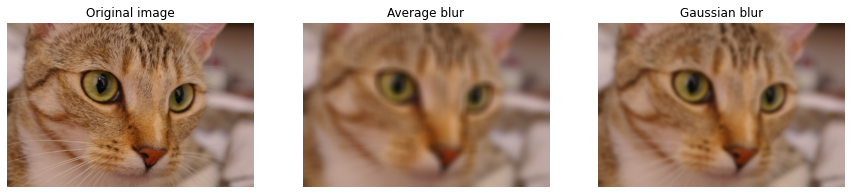

In [2]:
# Original image
img = data.chelsea()
print('Shape:', img.shape)
ksize = 15

plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original image')
#plt.subplot(322)
#hist = cv2.calcHist([img],[0],None,[256],[0,256])
#plt.plot(hist)

# Average filter
img_blurred = cv2.blur(img,(ksize,ksize))
plt.subplot(132)
plt.imshow(img_blurred, cmap='gray')
plt.axis('off')
plt.title('Average blur')
#plt.subplot(324)
#hist = cv2.calcHist([img_blurred],[0],None,[256],[0,256])
#plt.plot(hist)

# Gaussian filter
img_blurred = cv2.GaussianBlur(img,(ksize,ksize),0)
plt.subplot(133)
plt.imshow(img_blurred, cmap='gray')
plt.axis('off')
plt.title('Gaussian blur')
#plt.subplot(326)
#hist = cv2.calcHist([img_blurred],[0],None,[256],[0,256])
#plt.plot(hist)

plt.show()

# Remove noise using filters

## Gaussian noise -> gaussian blur
On greyscale image

In [3]:
from skimage.color import rgb2gray

def create_noise(shape):
    mean = 0
    var = 20
    sigma = var ** 0.5
    noise = np.random.normal(mean, sigma, shape)
    return noise

def apply_noise(img, intensity):
    noise = create_noise(img.shape)
    img_noise = img + (noise * intensity)
    img_noise = (img_noise - img_noise.mean()) / img_noise.std()
    return img_noise

min, max, dtype of input image: 0.01512078431372549 0.7556109803921569 float64


[]

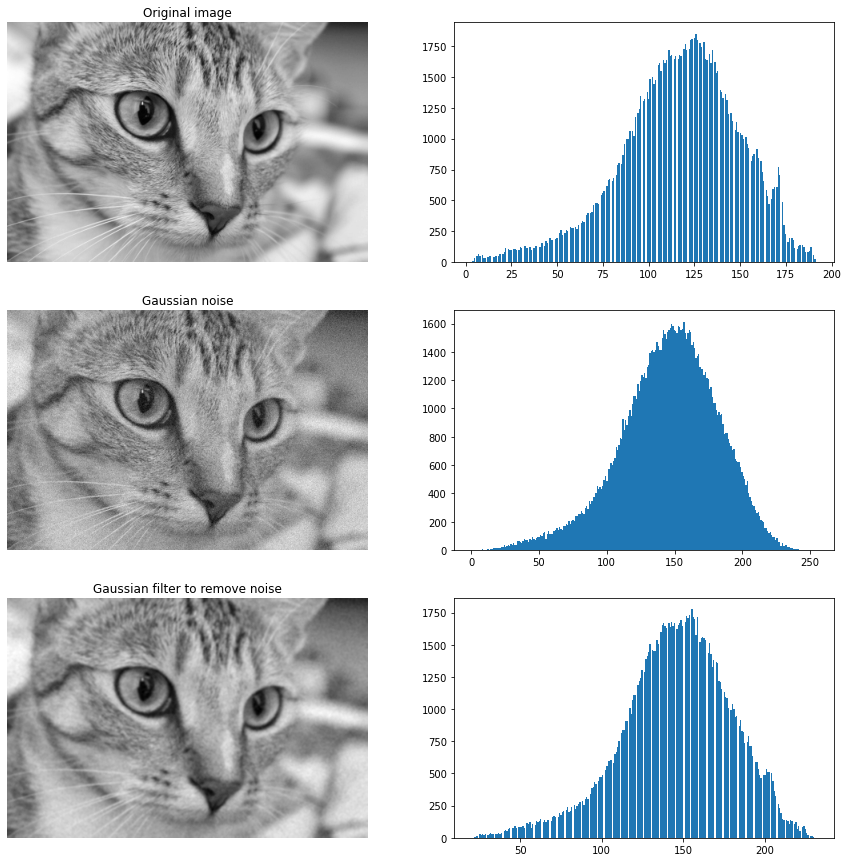

In [4]:
img = rgb2gray(data.chelsea())
print('min, max, dtype of input image:', np.amin(img), np.amax(img), img.dtype)
img = (img*255).astype(np.uint8)
height,width = np.shape(img)

plt.figure(figsize=(15, 15))
# Original image
plt.subplot(321)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.subplot(322)
plt.hist(img.ravel(), bins=256)
# alternative method for hist
#hist = cv2.calcHist([img],[0],None,[256],[0,256])

img_noised = apply_noise(img, 2)
cv2.normalize(img_noised, img_noised, 0, 255, cv2.NORM_MINMAX, dtype=-1)
img_noised = img_noised.astype(np.uint8)
plt.subplot(323)
plt.imshow(img_noised, cmap='gray')
plt.axis('off')
plt.title('Gaussian noise')
plt.subplot(324)
plt.hist(img_noised.ravel(), bins=256)

# Gaussian filter
img_blurred = cv2.GaussianBlur(img_noised,(5,5),0)
plt.subplot(325)
plt.imshow(img_blurred, cmap='gray')
plt.axis('off')
plt.title('Gaussian filter to remove noise')
plt.subplot(326)
plt.hist(img_blurred.ravel(), bins=256)

plt.plot()

## Salt & Pepper -> average blur
Here, the function cv2.medianBlur() computes the median of all the pixels under the kernel window and the central pixel is replaced with this median value. 

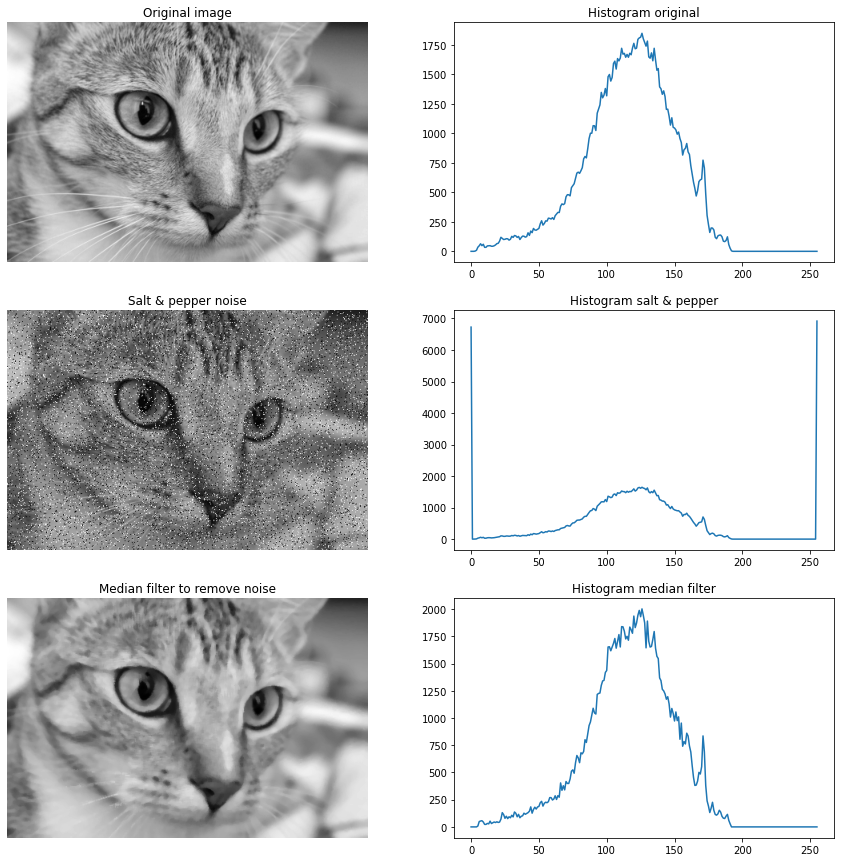

In [5]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

img = (rgb2gray(data.chelsea())*255).astype(np.uint8)

plt.figure(figsize=(15, 15))
# Original image
plt.subplot(321)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.subplot(322)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.title('Histogram original')
plt.plot(hist)

# Noised image
img_noised = sp_noise(img,0.05)
plt.subplot(323)
plt.imshow(img_noised, cmap='gray')
plt.axis('off')
plt.title('Salt & pepper noise')
plt.subplot(324)
hist = cv2.calcHist([img_noised],[0],None,[256],[0,256])
plt.title('Histogram salt & pepper')
plt.plot(hist)

# Median filter
img_blurred = cv2.medianBlur(img_noised,5)
plt.subplot(325)
plt.imshow(img_blurred, cmap='gray')
plt.axis('off')
plt.title('Median filter to remove noise')
plt.subplot(326)
hist = cv2.calcHist([img_blurred],[0],None,[256],[0,256])
plt.title('Histogram median filter')
plt.plot(hist)

plt.show()

We see that a simple median filter almost removed all the salt & pepper noise. The histogram looks also very similar to the original one. Amazing !

# Edges options in convolutions

On the gif above, we see that we move the filter around the image. What should if the padding is > 0 (we get outside of the image during the operation) ?
- we consider that outside of the image we have constant values (often zero=black) -> mode constant
- we consider the image repeats itseft -> mode wrap
- we consider that the image is reflected along borders -> mode reflect, often most good-looking

> NB: here we create blur using **Average filtering** instead of Gaussian filtering. We do it using a kernel of ones multiplied by coeff 1/k^2, also called uniform filter. Usually Gaussian blur has a more "natural" look than uniform blur. Instead of creating manually the filters, most image processing & cnn libraries have functions to directly perform a uniform or gaussian filtering.

In [6]:
from scipy import ndimage

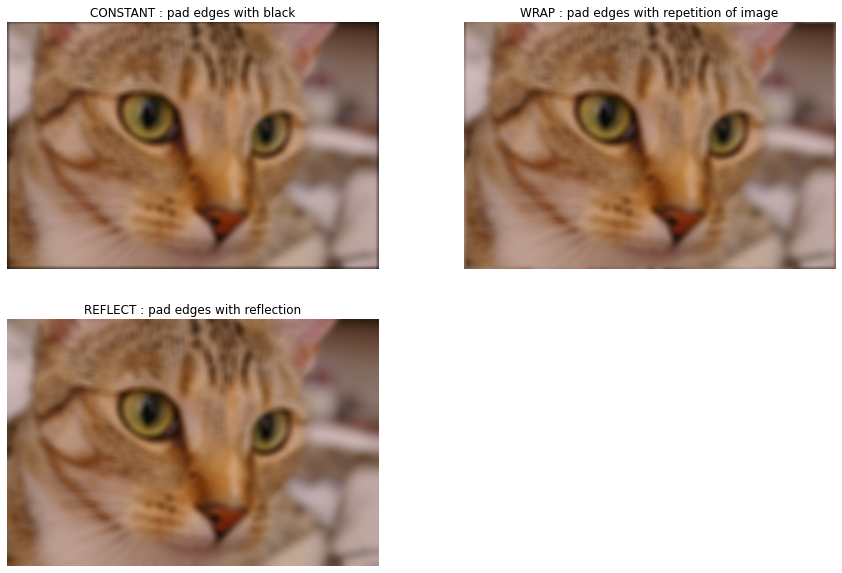

In [7]:
img_base = data.chelsea()
k = 1/81*np.ones((9,9,1))

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(ndimage.convolve(img_base, k, mode='constant', cval=0.0))
plt.axis('off')
plt.title('CONSTANT : pad edges with black')

plt.subplot(222)
img = ndimage.convolve(img_base, k, mode='wrap', cval=0.0)
plt.imshow(img)
plt.axis('off')
plt.title('WRAP : pad edges with repetition of image')

plt.subplot(223)
img = ndimage.convolve(img_base, k, mode='reflect', cval=0.0)
plt.imshow(img)
plt.axis('off')
plt.title('REFLECT : pad edges with reflection')

plt.show()

# Template matching

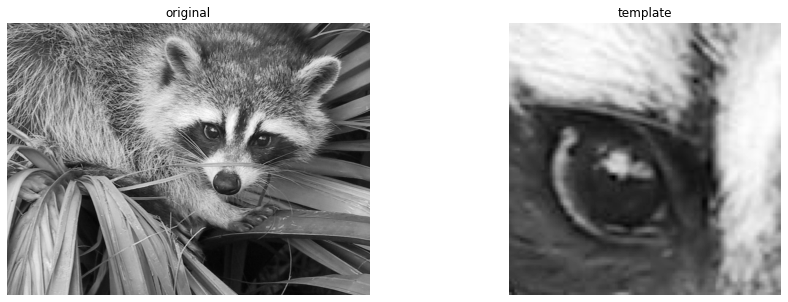

In [8]:
from scipy import misc

racoon_img = misc.face(gray=True)
# normalize image by deviding by mean
img = racoon_img - racoon_img.mean()
template = np.copy(img[250:350, 540:640]) # left eye
template -= template.mean()

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("original")
plt.subplot(122)
plt.imshow(template, cmap='gray')
plt.axis("off")
plt.title("template")
plt.show()

# add noise to original image
img = img + np.random.randn(*img.shape) * 50 

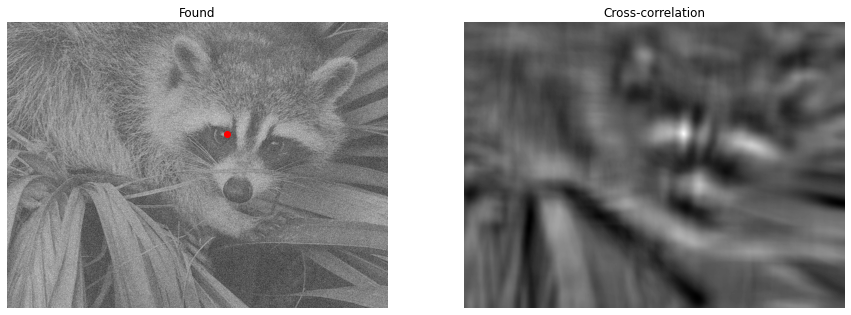

In [9]:
# correlation map
corr = ndimage.correlate(img, template)
# find the coords where there is the best match
# y, x = np.unravel_index(np.argmax(corr), corr.shape)
max_val = np.amax(corr)
y,x = np.where(corr == max_val)

fig, (ax_orig, ax_corr) = plt.subplots(1, 2, figsize=(15,15))
ax_orig.imshow(img, cmap='gray')
ax_orig.set_title('Found')
ax_orig.set_axis_off()
ax_corr.imshow(corr, cmap='gray')
ax_corr.set_title('Cross-correlation')
ax_corr.set_axis_off()
ax_orig.plot(x, y, 'ro')
plt.show()

The templated is matched where the cross-correlation has the highest value. Of course if we are not sure the template is within the image we should set a threshold so that we consider if `max(cross-corr) < thres` the template is not found.

**Important**: We show here a simple version of template matching. But in real life we are not sure the target will have the correct size in the image, which is why we should loop over different scales of the image ! See <a href="https://www.pyimagesearch.com/2015/01/26/multi-scale-template-matching-using-python-opencv/">here a tuto</a>